In [1]:
from torch.utils.data import DataLoader
from torch import nn
from datasets.imdb import get_imdb_train_or_test, get_training_for_triplet_loss_imdb
from datasets.blog import get_blogs_train_or_test, get_training_for_triplet_loss_blogs
from AaEvaluator import AaEvaluator
from sentence_transformers import SentenceTransformer, SentencesDataset, losses, models, evaluation

import mlflow
import argparse
import time
import os

from tqdm.notebook import tqdm 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [5]:
get_train_or_test = get_imdb_train_or_test

test_dataset_path = '/home/jtyo/Repos/AuthorshipAttribution/data/IMDB/imdb62-test.txt'

test_dataset = get_train_or_test(test_dataset_path, as_dict=True)

model_path = '/home/jtyo/Repos/AuthorshipAttribution/output/BatchHardSoftMargin'
device = 'cuda:0'

model = SentenceTransformer(model_path, device=device)

# pass the dataset through the model to get the embeddings we need
outputs = []
auths = {}
counter = 0

for auth, texts in tqdm(test_dataset.items()):
    
    if auth not in auths.keys():
        auths[auth] = counter
        counter += 1
        
    for i in range(len(texts)):
        outputs.append((model.encode(texts[i], convert_to_numpy=True), auths[auth]))
        

  0%|          | 0/62 [00:00<?, ?it/s]

In [52]:
# now calculate tsne embeddings
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, n_jobs=10) 
x = np.array([i[0] for i in outputs])
y = np.array([i[1] for i in outputs])
tsne_embeddings = tsne.fit_transform(x)

In [53]:
print(max(tsne_embeddings.flatten()))
print(len(tsne_embeddings))
print(np.array(tsne_embeddings)[:, 0])
tsne_embeddings = np.array(tsne_embeddings)

91.99605
12400
[-50.142303  -49.90623   -48.900894  ...   3.4836903   0.348887
   1.4550046]


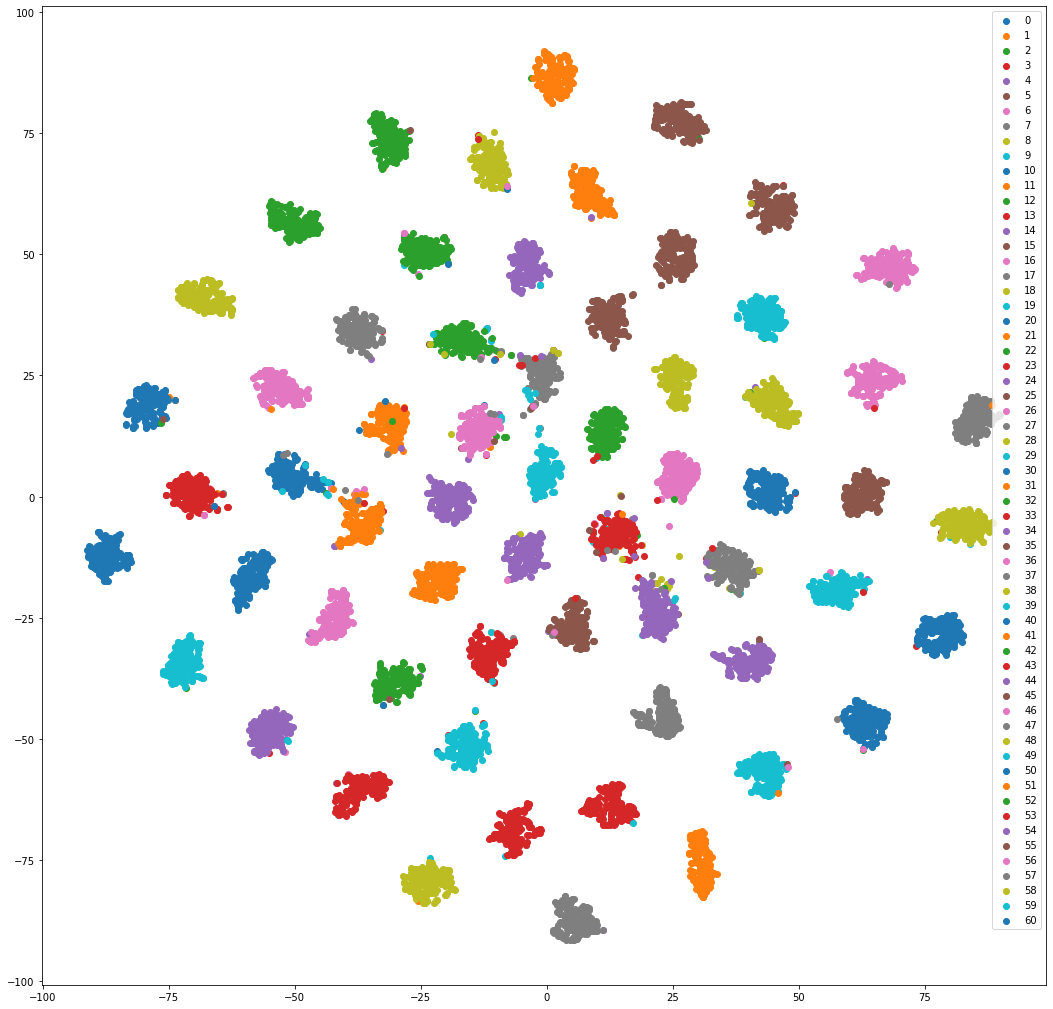

In [54]:
# plot the embeddings
plt.figure(figsize=(18, 18))
tmp = [(tsne_embeddings[i][0], tsne_embeddings[i][1], y[i]) for i in range(len(tsne_embeddings))]
# print('starting plotting')
for i in range(max(y)):
    ys = np.where(y == i)
#     if i == 0:
#         print(ys)
#         print(tsne_embeddings[ys, 0])
    plt.scatter(tsne_embeddings[ys, 0], tsne_embeddings[ys, 1], label = i)
    
#for x1, x2, y_i in tmp:
#plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], label=np.array(y))
plt.legend()
plt.show()

In [55]:
import time

# how long does it take to embed the entire dataset? 
get_train_or_test = get_imdb_train_or_test

test_dataset_path = '/home/jtyo/Repos/AuthorshipAttribution/data/IMDB/imdb62-train.txt'

test_dataset = get_train_or_test(test_dataset_path, as_dict=True)

model_path = '/home/jtyo/Repos/AuthorshipAttribution/output/BatchHardSoftMargin'
device = 'cuda:0'

model = SentenceTransformer(model_path, device=device)

# pass the dataset through the model to get the embeddings we need
outputs = []

start_time = time.time()

for auth, texts in tqdm(test_dataset.items()):
    
    for i in range(len(texts)):
        outputs = model.encode(texts[i], convert_to_numpy=True)
        
print(f'Elapsed time: {time.time() - start_time}')

  0%|          | 0/62 [00:00<?, ?it/s]

Elapsed time: 684.4600558280945


In [2]:
# build the TSNE plot for blogs dataset
get_train_or_test = get_blogs_train_or_test

test_dataset_path = '/home/jtyo/Repos/AuthorshipAttribution/data/Blog/blogs-top100-test.json'

test_dataset = get_train_or_test(test_dataset_path, as_dict=True)

model_path = '/home/jtyo/Repos/AuthorshipAttribution/src/AuthorshipAttribution/notebooks/blogs_all_bigb_hs_cont'
device = 'cuda:0'

model = SentenceTransformer(model_path, device=device)

# pass the dataset through the model to get the embeddings we need
outputs = []
auths = {}
counter = 0

for auth, texts in tqdm(test_dataset.items()):
    
    if auth not in auths.keys():
        auths[auth] = counter
        counter += 1
        
    for i in range(len(texts)):
        outputs.append((model.encode(texts[i], convert_to_numpy=True), auths[auth]))
        

  0%|          | 0/100 [00:00<?, ?it/s]

In [3]:
# now calculate tsne embeddings
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, n_jobs=10) 
x = np.array([i[0] for i in outputs])
y = np.array([i[1] for i in outputs])
tsne_embeddings = tsne.fit_transform(x)
print(max(tsne_embeddings.flatten()))
print(len(tsne_embeddings))
print(np.array(tsne_embeddings)[:, 0])
tsne_embeddings = np.array(tsne_embeddings)

85.390335
22564
[ 11.692125   20.119267  -17.104607  ...   6.5596285  34.530106
 -45.976032 ]


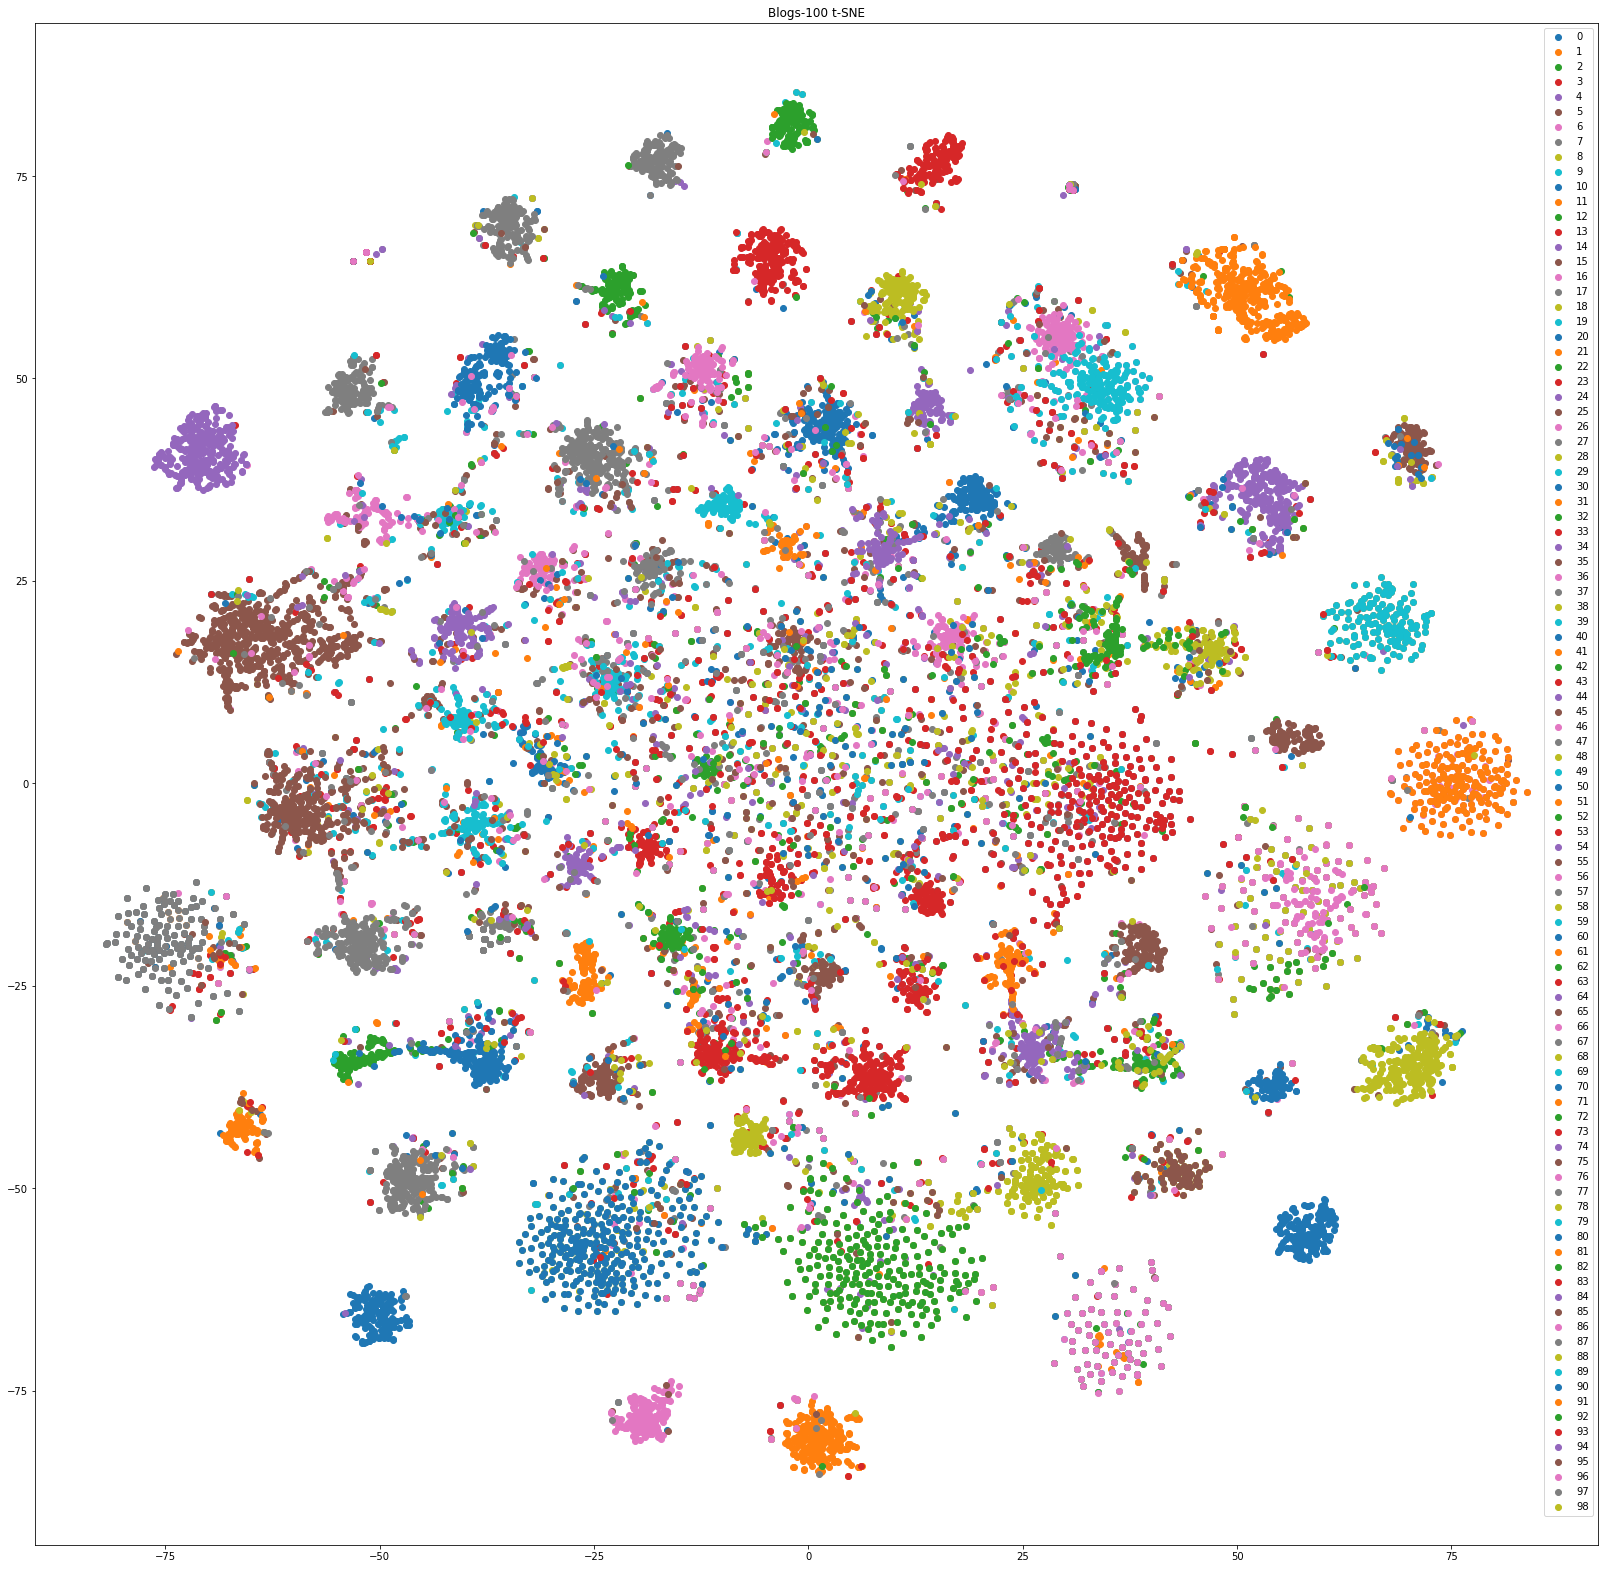

In [8]:
# plot the embeddings
plt.figure(figsize=(28, 28))
tmp = [(tsne_embeddings[i][0], tsne_embeddings[i][1], y[i]) for i in range(len(tsne_embeddings))]
# print('starting plotting')
for i in range(max(y)):
    ys = np.where(y == i)
#     if i == 0:
#         print(ys)
#         print(tsne_embeddings[ys, 0])
    plt.scatter(tsne_embeddings[ys, 0], tsne_embeddings[ys, 1], label = i)
    
#for x1, x2, y_i in tmp:
#plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], label=np.array(y))
plt.legend()
plt.title('Blogs-100 t-SNE')
plt.show()

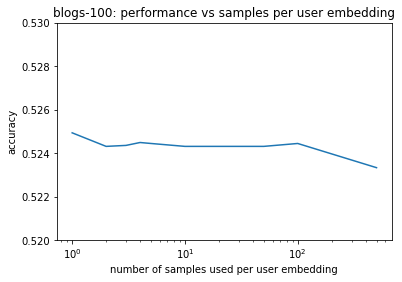

In [12]:
blogs = [(1, 0.5249287749287749),
(2, 0.5243055555555556),
(3, 0.5243500712250713),
(4, 0.5244836182336182),
(5, 0.5244391025641025),
(10, 0.5243055555555556),
(25, 0.5243055555555556),
(50, 0.5243055555555556),
(100, 0.5244391025641025),
(500, 0.5233262108262108)]

x = [b[0] for b in blogs]
y = [b[1] for b in blogs]

plt.plot(x, y)
plt.ylim(0.52, 0.53)
plt.xscale('log')
plt.ylabel('accuracy')
plt.xlabel('number of samples used per user embedding')
plt.title('blogs-100: performance vs samples per user embedding')
plt.show()

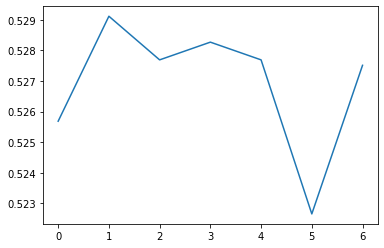

In [13]:
sbertblogsone = [0.5256855413105413,
0.5291132478632479,
0.5276887464387464,
0.5282674501424501,
0.5276887464387464,
0.5226584757834758,
0.5275106837606838]


x = [i for i, j in enumerate(sbertblogsone)]

plt.plot(x, sbertblogsone)

In [15]:
a = np.array(sbertblogsone)
print(np.mean(a))
print(np.max(a))
print(np.min(a))
print(np.median(a))


0.5269446988196987
0.5291132478632479
0.5226584757834758
0.5276887464387464
